In [8]:
!pip install scikit-optimize
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=70cfb8201be1f0f0bc398e2e6e7b7cbcf40828fe09f3c0e268d5b268d716cebf
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [30]:
import pandas as pd
import numpy as np
import shap
import json
from flask import Flask, request,jsonify
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from skopt import BayesSearchCV

In [26]:
# Try importing LIME and handle errors
try:
    import lime
    import lime.lime_tabular
    lime_available = True
except ModuleNotFoundError:
    print("LIME is not installed. Skipping LIME explanations.")
    lime_available = False

In [10]:
# Load dataset (Replace with actual dataset path)
df = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [12]:
df['Over18'].value_counts()

,count
Over18,
Y,1470


In [13]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [14]:
df = df.drop(['EmployeeCount','Over18'], axis = 1)

In [15]:
df['Attrition']=df['Attrition'].apply(lambda x : 1 if x=='Yes' else 0)


In [16]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,4,80,1,6,3,3,2,2,2,2


In [17]:
df = pd.get_dummies(df)

In [18]:
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1,1102,1,2,1,2,94,3,2,...,False,False,False,True,False,False,False,True,False,True
1,49,0,279,8,1,2,3,61,2,2,...,False,False,True,False,False,False,True,False,True,False
2,37,1,1373,2,2,4,4,92,2,1,...,False,False,False,False,False,False,False,True,False,True
3,33,0,1392,3,4,5,4,56,3,1,...,False,False,True,False,False,False,True,False,False,True
4,27,0,591,2,1,7,1,40,3,1,...,False,False,False,False,False,False,True,False,True,False


In [19]:
#Separating Feature and Target matrices
X = df.drop(['Attrition'], axis=1)
y=df['Attrition']

In [20]:
# Data Preprocessing
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

scaler = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])


<ipython-input-20-7dd2b072f717>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.4463504   1.32236521  0.008343   ... -1.08667552  1.32236521
 -0.32016256]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
<ipython-input-20-7dd2b072f717>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2.28090588 -0.4384223   2.28090588 ... -0.4384223  -0.4384223
 -0.4384223 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
<ipython-input-20-7dd2b072f717>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.74252653 -1.2977746   1.41436324 ... -1.60518328  0.54667746
 -0.43256792]' has dtype in

In [21]:
# Splitting Data
X = df.drop("Attrition", axis=1)
y = df["Attrition"].apply(lambda x: 1 if x > 0 else 0).astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Function to evaluate model and plot confusion matrix
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).astype(int) if model_name == "ANN" else y_pred  # Ensure ANN outputs are binary
    print(f"{model_name} Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attrition', 'Attrition'], yticklabels=['No Attrition', 'Attrition'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


Logistic Regression Accuracy: 0.8843537414965986
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       255
           1       0.58      0.46      0.51        39

    accuracy                           0.88       294
   macro avg       0.75      0.71      0.72       294
weighted avg       0.88      0.88      0.88       294

Confusion Matrix:
[[242  13]
 [ 21  18]]


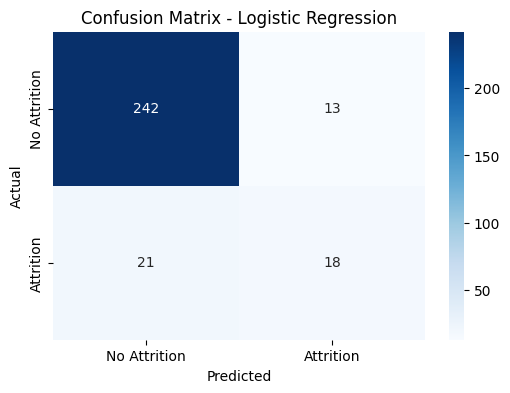

Random Forest Accuracy: 0.8673469387755102
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       255
           1       0.50      0.08      0.13        39

    accuracy                           0.87       294
   macro avg       0.69      0.53      0.53       294
weighted avg       0.83      0.87      0.82       294

Confusion Matrix:
[[252   3]
 [ 36   3]]


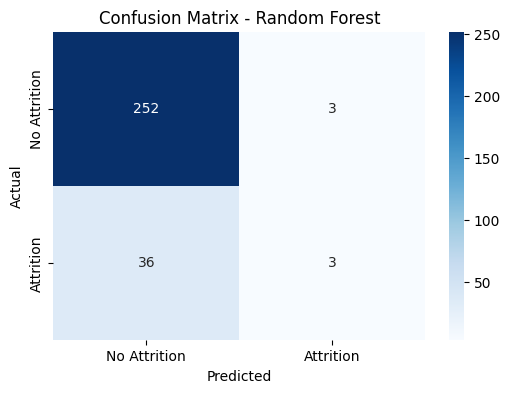

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:46:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8775510204081632
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       255
           1       0.59      0.26      0.36        39

    accuracy                           0.88       294
   macro avg       0.74      0.61      0.64       294
weighted avg       0.85      0.88      0.86       294

Confusion Matrix:
[[248   7]
 [ 29  10]]


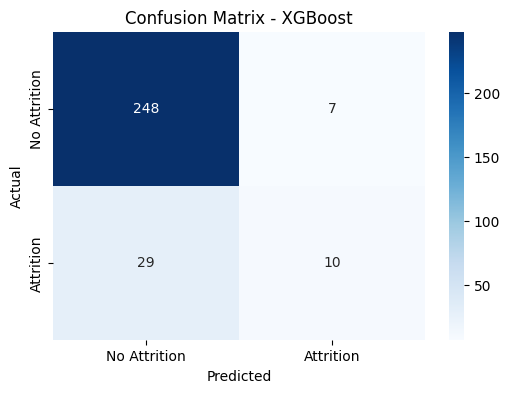

SVM Accuracy: 0.8945578231292517
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       255
           1       0.90      0.23      0.37        39

    accuracy                           0.89       294
   macro avg       0.90      0.61      0.65       294
weighted avg       0.90      0.89      0.87       294

Confusion Matrix:
[[254   1]
 [ 30   9]]


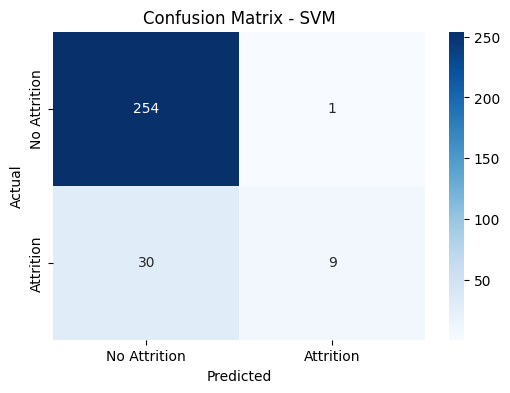

KNN Accuracy: 0.8877551020408163
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       255
           1       0.71      0.26      0.38        39

    accuracy                           0.89       294
   macro avg       0.81      0.62      0.66       294
weighted avg       0.87      0.89      0.86       294

Confusion Matrix:
[[251   4]
 [ 29  10]]


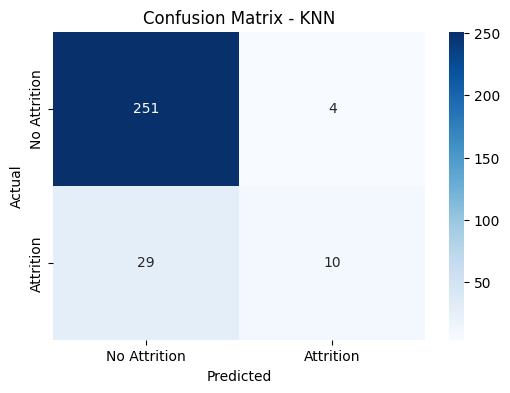

Decision Tree Accuracy: 0.7755102040816326
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       255
           1       0.21      0.26      0.23        39

    accuracy                           0.78       294
   macro avg       0.55      0.56      0.55       294
weighted avg       0.79      0.78      0.78       294

Confusion Matrix:
[[218  37]
 [ 29  10]]


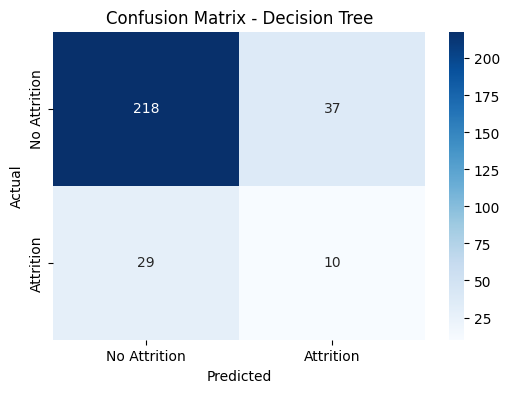

In [23]:
# Train and evaluate models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(model, X_test, y_test, name)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7603 - loss: 0.5549
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8387 - loss: 0.4054
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8432 - loss: 0.3642
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8792 - loss: 0.2869
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8879 - loss: 0.2836
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8969 - loss: 0.2604
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9027 - loss: 0.2444
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9058 - loss: 0.2277
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9289 - loss: 0.1938
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9241 - loss: 0.1927
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
ANN Accuracy: 0.8707482993197279
              precision    recall  f1-score   support

           0       0.92      0.94      0.93

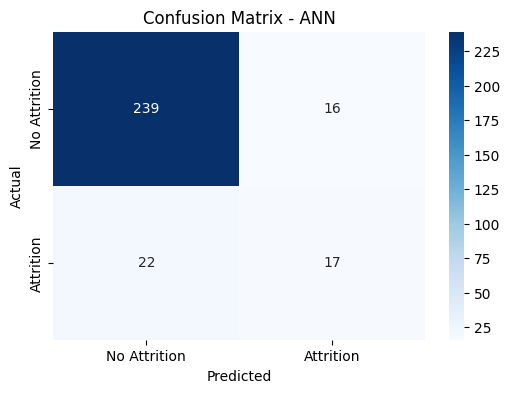

In [24]:
# Artificial Neural Network (ANN)
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
evaluate_model(ann_model, X_test, y_test, "ANN")

In [27]:
# LIME Explanation (for Random Forest, if available)
if lime_available:
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns.tolist(), class_names=['No Attrition', 'Attrition'], discretize_continuous=True)
    lime_instance = X_test.iloc[0].values
    lime_exp = lime_explainer.explain_instance(lime_instance, models["Random Forest"].predict_proba, num_features=5)
    lime_exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


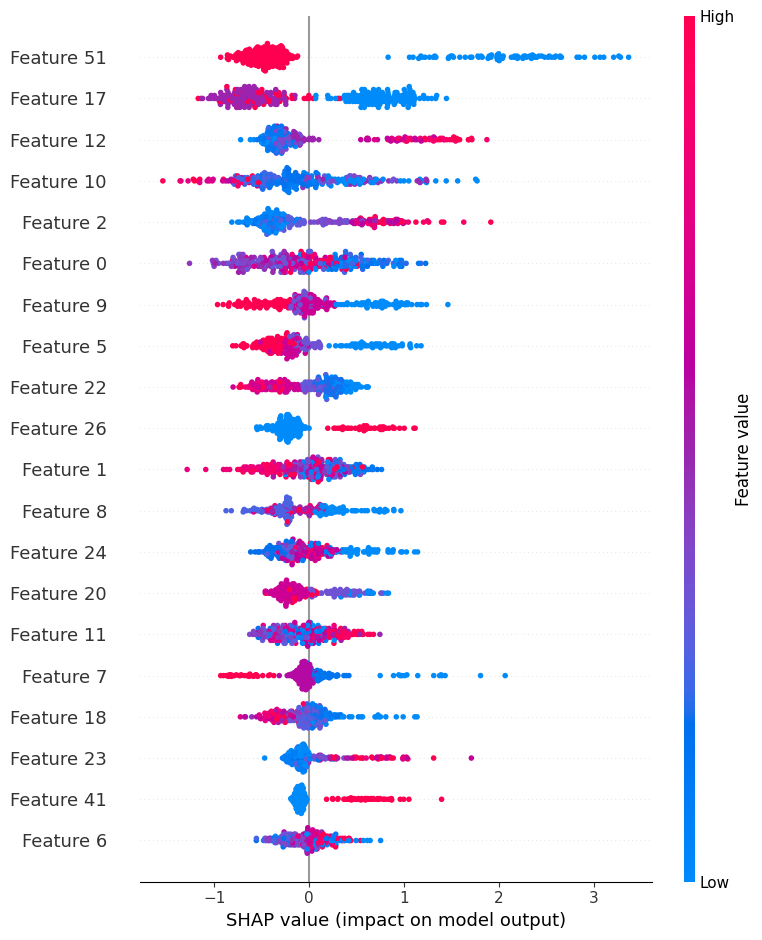

In [29]:

# SHAP Explanation (for XGBoost)
X_train_np = X_train.to_numpy().astype(float)
X_test_np = X_test.to_numpy().astype(float)
explainer = shap.Explainer(models["XGBoost"], X_train_np)
shap_values = explainer(X_test_np)
shap.summary_plot(shap_values, X_test_np)


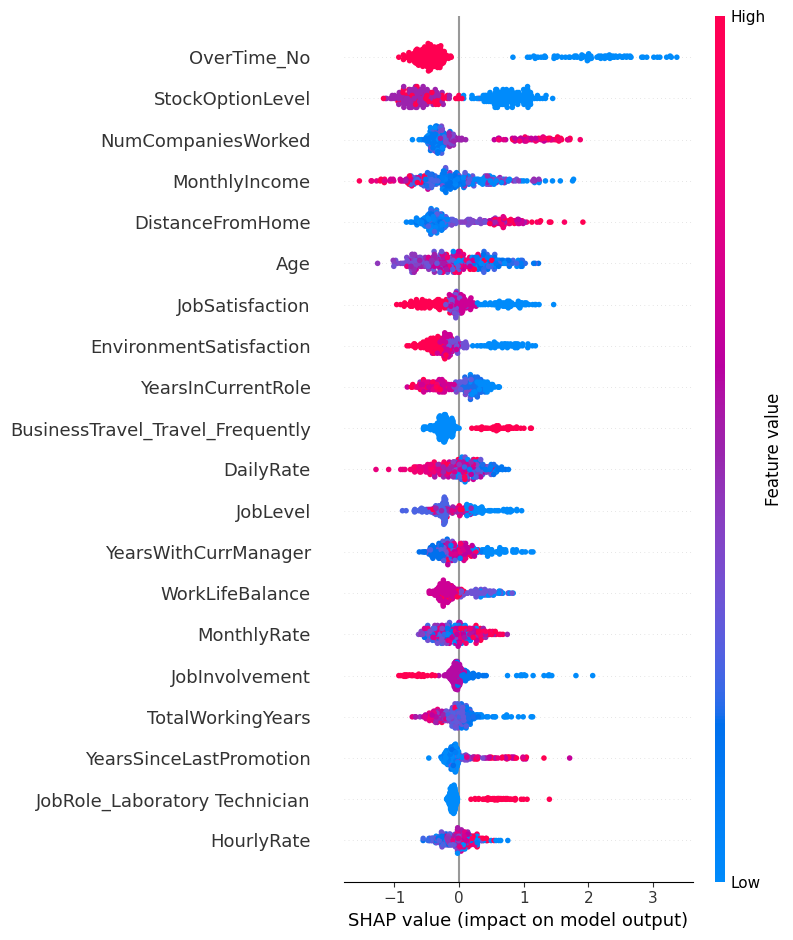

In [38]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [31]:
# Hyperparameter Tuning - GridSearchCV (Random Forest Example)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters (GridSearchCV):", grid_search.best_params_)



Best Parameters (GridSearchCV): {'max_depth': 10, 'n_estimators': 50}


In [32]:
# Hyperparameter Tuning - RandomizedSearchCV (XGBoost Example)
param_dist = {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200, 300]}
random_search = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
print("Best Parameters (RandomizedSearchCV):", random_search.best_params_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:00:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:00:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:00:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:00:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:00:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Parameters (RandomizedSearchCV): {'n_estimators': 300, 'learning_rate': 0.1}


In [33]:
# Hyperparameter Tuning - Bayesian Optimization (SVM Example)
param_space = {'C': (0.1, 10.0, 'log-uniform'), 'gamma': (0.01, 1.0, 'log-uniform')}
bayes_search = BayesSearchCV(SVC(), param_space, n_iter=5, cv=5, scoring='accuracy', random_state=42)
bayes_search.fit(X_train, y_train)
print("Best Parameters (Bayesian Optimization):", bayes_search.best_params_)

Best Parameters (Bayesian Optimization): OrderedDict([('C', 4.2149456283335), ('gamma', 0.022066991249460103)])


In [ ]:
# Save Best Model
joblib.dump(grid_search.best_estimator_, "employee_attrition_model.pkl")
print("Model saved as employee_attrition_model.pkl")

Model saved as employee_attrition_model.pkl
